#### Author:Nick Koutantos
#### Date:August 2022
##### Data Source : https://www.kaggle.com/datasets/nicholasjhana/energy-consumption-generation-prices-and-weather?resource=download

In [1]:
#Packages
import pandas as pd
from datetime import datetime
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from utils.helpers import add_freq
import plotly.express as px
import pandas_datareader as pdr
import plotly.figure_factory as ff


In [2]:
#Data cleaning with usage of a helper function , which is included in the folder utils
#Purspose of this function is to clean the given dataset each time of usage and it also adds
#timestamped index as well as a condition of the given months.
from utils.helpers import energy_clean
df_energy = energy_clean("./data/energy_dataset.csv")

In [3]:
df_energy.describe()

,generation biomass,generation fossil brown coal/lignite,generation fossil gas,generation fossil hard coal,generation fossil oil,generation hydro pumped storage consumption,generation hydro run-of-river and poundage,generation hydro water reservoir,generation nuclear,generation other,generation other renewable,generation solar,generation waste,generation wind onshore,forecast solar day ahead,forecast wind onshore day ahead,total load forecast,total load actual,price day ahead,price actual
count,35045.000000,35046.000000,35046.000000,35046.000000,35045.000000,35045.000000,35045.000000,35046.000000,35047.000000,35046.000000,35046.000000,35046.000000,35045.000000,35046.000000,35064.000000,35064.000000,35064.000000,35028.000000,35064.000000,35064.000000
mean,383.513540,448.059208,5622.737488,4256.065742,298.319789,475.577343,972.116108,2605.114735,6263.907039,60.228585,85.639702,1432.665925,269.452133,5464.479769,1439.066735,5471.216689,28712.129962,28696.939905,49.874341,57.884023
std,85.353943,354.568590,2201.830478,1961.601013,52.520673,792.406614,400.777536,1835.199745,839.667958,20.238381,14.077554,1680.119887,50.195536,3213.691587,1677.703355,3176.312853,4594.100854,4574.987950,14.618900,14.204083
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,237.000000,18105.000000,18041.000000,2.060000,9.330000
25%,333.000000,0.000000,4126.000000,2527.000000,263.000000,0.000000,637.000000,1077.250000,5760.000000,53.000000,73.000000,71.000000,240.000000,2933.000000,69.000000,2979.000000,24793.750000,24807.750000,41.490000,49.347500
50%,367.000000,509.000000,4969.000000,4474.000000,300.000000,68.000000,906.000000,2164.000000,6566.000000,57.000000,88.000000,616.000000,279.000000,4849.000000,576.000000,4855.000000,28906.000000,28901.000000,50.520000,58.020000
75%,433.000000,757.000000,6429.000000,5838.750000,330.000000,616.000000,1250.000000,3757.000000,7025.000000,80.000000,97.000000,2578.000000,310.000000,7398.000000,2636.000000,7353.000000,32263.250000,32192.000000,60.530000,68.010000
max,592.000000,999.000000,20034.000000,8359.000000,449.000000,4523.000000,2000.000000,9728.000000,7117.000000,106.000000,119.000000,5792.000000,357.000000,17436.000000,5836.000000,17430.000000,41390.000000,41015.000000,101.990000,116.800000


## Model Creation
### For the model creation I have used a library which is called ScaleCast and it includes different kinds of mdoels with focus on Time Series 
### forecasting.It constitutes a stable and fast implementation of the known models and especially LSTMs , which I will use below
#### Reference : https://github.com/mikekeith52/scalecast

In [4]:
from scalecast.Forecaster import Forecaster
add_freq(df_energy.index) # Addition of frequency in the index column
# Load of the dataset and more spesifically the Total Loads Actual
f = Forecaster(y=df_energy['total load actual'], current_dates=df_energy.index.tz_localize(None))

#### Below the Series of manipulation is been given and also the Autocorrelation graph, 
#### which gives us an exlanation about the similiraties of the Series and its past values.
#### After two years it shows a very high degree of correlation and this is why , I am moving forward 
#### a preprossecing of the given data.

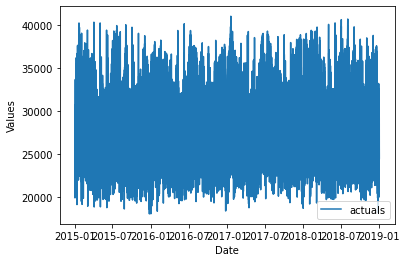

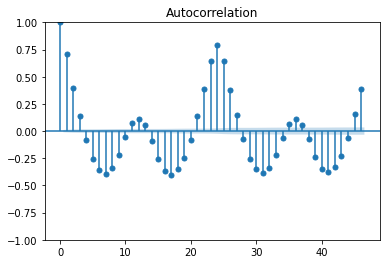

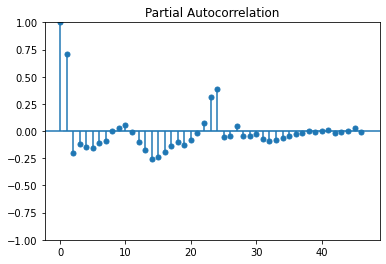

In [6]:
#A basic plot of the Time series and the Autocorrelationd.
f.plot()
f.plot_acf(diffy=True)
f.plot_pacf(diffy=True)
plt.show()

#### Based on Time Series theories the seasonal decompose gives us the given data 
#### into four different objects in order to express the same dataset.
#### As shown below there is no seasonality in the loads of Spain

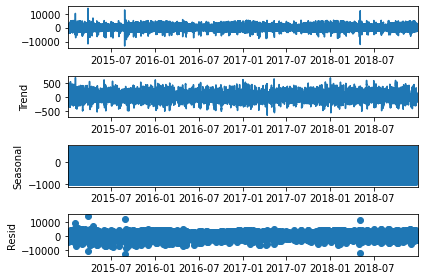

In [7]:
f.seasonal_decompose(diffy=True).plot()
plt.show()

In [8]:
f.set_test_length(36)#36 months for the test set
f.generate_future_dates(12)
f.add_ar_terms(4) # 4 AR terms
f.add_AR_terms((2,12)) # 2 seasonal AR terms

series appears to be stationary


<AxesSubplot:xlabel='Date', ylabel='Values'>

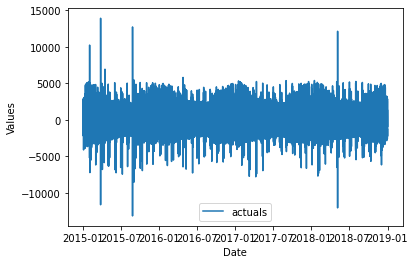

In [18]:
f.diff()
f.adf_test(quiet=False)
f.plot()

In [9]:
#Adding seasonality based on the month.
f.add_seasonal_regressors('month',raw=False,sincos=True)
f.add_seasonal_regressors('year')


#### First implementation of the lstm with the default values

In [10]:
f.set_estimator('lstm')
f.manual_forecast(call_me='lstm_default')

1095/1095 [==============================] - 5s 3ms/step - loss: 0.1833


#### A second implementation with more lags in the model

In [15]:
f.manual_forecast(call_me='lstm_24lags',lags=24)

1094/1094 [==============================] - 12s 9ms/step - loss: 0.1752


#### A final implementation with the addition of a heavy duty lstm , which results in a very good loss function 
#### in comparison with the previous two models.It took almost an hour for the train with 4 hidden layers and a 
#### very short learning rate in order to exclude valuable information of the dataset.The loss function 
#### is shown below.

Epoch 1/15
873/873 [==============================] - 70s 73ms/step - loss: 0.1118 - val_loss: 0.0922
Epoch 2/15
873/873 [==============================] - 84s 96ms/step - loss: 0.0842 - val_loss: 0.0860
Epoch 3/15
873/873 [==============================] - 89s 102ms/step - loss: 0.0788 - val_loss: 0.0819
Epoch 4/15
873/873 [==============================] - 92s 106ms/step - loss: 0.0744 - val_loss: 0.0824
Epoch 5/15
873/873 [==============================] - 93s 107ms/step - loss: 0.0718 - val_loss: 0.0776
Epoch 6/15
873/873 [==============================] - 94s 108ms/step - loss: 0.0694 - val_loss: 0.0760
Epoch 7/15
873/873 [==============================] - 87s 99ms/step - loss: 0.0675 - val_loss: 0.0736
Epoch 8/15
873/873 [==============================] - 86s 98ms/step - loss: 0.0656 - val_loss: 0.0738
Epoch 9/15
873/873 [==============================] - 88s 100ms/step - loss: 0.0641 - val_loss: 0.0711
Epoch 10/15
873/873 [==============================] - 86s 99ms/step - loss: 

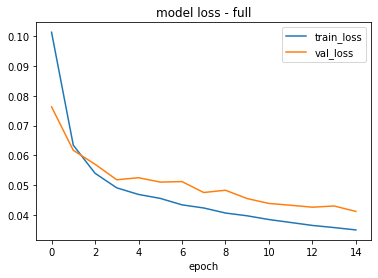

In [17]:
f.manual_forecast(call_me='lstm_24lags_4layers_15epochs',
                  lags=36,
                  batch_size=32,
                  epochs=15,
                  validation_split=.2,
                  shuffle=True,
                  activation='tanh',
                  optimizer='Adam',
                  learning_rate=0.001,
                  lstm_layer_sizes=(72,)*4,
                  dropout=(0,)*4,
                  plot_loss=True)

#### With Scalecast we have the abillity to visualise all the results into one , due to the fact 
#### that `f` includes all the model information at once

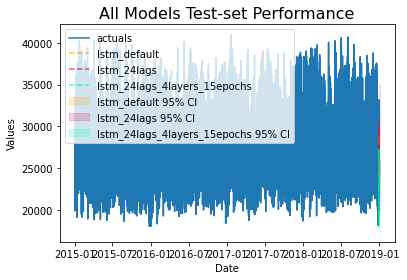

In [18]:
f.plot_test_set(ci=True)
plt.title('All Models Test-set Performance',size=16)
plt.show()